# Visualise Heatmaps

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Xmaster6y/lczerolens/blob/main/docs/source/notebooks/features/visualise-saliency-heatmaps.ipynb)

## Setup

In [1]:
MODE = "local"  # "colab" | "colab-dev" | "local"

In [2]:
if MODE == "colab":
    !pip install -q lczerolens[hf]
elif MODE == "colab-dev":
    !rm -r lczerolens
    !git clone https://github.com/Xmaster6y/lczerolens -b main
    !pip install -q ./lczerolens --extra hf

## Visualise Attention

In [3]:
from lczerolens import LczeroModel
from lczerolens import LczeroBoard

from tdhook.latent.activation_caching import ActivationCaching


transformer_model = LczeroModel.from_hf("lczerolens/evidence-of-learned-lookahead")
board = LczeroBoard(fen="1rb1rbk1/2qn1p1p/p2p2p1/1ppPp2n/PP2P3/2P1BN1P/R1BN1PP1/3QR1K1 w - - 0 22")

hooking_context = ActivationCaching(key_pattern="encoder\d+/mha/QK/softmax", relative=True).prepare(transformer_model)

with hooking_context as hooked_model:
    hooked_model(board.to_input_tensor())
hooking_context.cache

/Users/xmaster/Work/Chess/lczerolens/.venv/lib/python3.12/site-packages/onnx2torch/node_converters/slice.py:63: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/python_variable_indexing.cpp:312.)
  x = x[pos_axes_slices]


TensorDict(
    fields={
        encoder0/mha/QK/softmax: Tensor(shape=torch.Size([1, 24, 64, 64]), device=cpu, dtype=torch.float32, is_shared=False),
        encoder1/mha/QK/softmax: Tensor(shape=torch.Size([1, 24, 64, 64]), device=cpu, dtype=torch.float32, is_shared=False),
        encoder10/mha/QK/softmax: Tensor(shape=torch.Size([1, 24, 64, 64]), device=cpu, dtype=torch.float32, is_shared=False),
        encoder11/mha/QK/softmax: Tensor(shape=torch.Size([1, 24, 64, 64]), device=cpu, dtype=torch.float32, is_shared=False),
        encoder12/mha/QK/softmax: Tensor(shape=torch.Size([1, 24, 64, 64]), device=cpu, dtype=torch.float32, is_shared=False),
        encoder13/mha/QK/softmax: Tensor(shape=torch.Size([1, 24, 64, 64]), device=cpu, dtype=torch.float32, is_shared=False),
        encoder14/mha/QK/softmax: Tensor(shape=torch.Size([1, 24, 64, 64]), device=cpu, dtype=torch.float32, is_shared=False),
        encoder2/mha/QK/softmax: Tensor(shape=torch.Size([1, 24, 64, 64]), device=cpu, d

In [4]:
import chess
import IPython.display

batch_index = 0
layer = 9
head = 5
piece = chess.F3

attention_weights = hooking_context.cache[f"encoder{layer}/mha/QK/softmax"][batch_index, head]
svg_board, svg_colorbar = board.render_heatmap(attention_weights[piece].detach())
display(IPython.display.HTML(f"{svg_board}{svg_colorbar}"))

## Visualise Gradients

In [5]:
from tdhook.attribution.saliency import Saliency
from tensordict import TensorDict

cnn_model = LczeroModel.from_hf("lczerolens/maia-1900")


def init_targets(td, _):
    return TensorDict(out=td["wdl"][..., 0], batch_size=td.batch_size)


td = TensorDict(board=cnn_model.prepare_boards(board), batch_size=1)

saliency_context = Saliency(init_attr_targets=init_targets)
with saliency_context.prepare(cnn_model) as hooked_model:
    output = hooked_model(td)

In [6]:
batch_index = 0
plane = 1  # N

svg_board, svg_colorbar = board.render_heatmap(
    output.get(("attr", "board"))[batch_index, plane].view(64).detach(), normalise="abs"
)
display(IPython.display.HTML(f"{svg_board}{svg_colorbar}"))

In [7]:
gap_input_grad = output.get(("attr", "board"))[:, :12].mean(dim=1)

svg_board, svg_colorbar = board.render_heatmap(gap_input_grad[batch_index].view(64).detach(), normalise="abs")
display(IPython.display.HTML(f"{svg_board}{svg_colorbar}"))

## GradCAM

### Loking at the value

In [8]:
from tdhook.attribution.grad_cam import GradCAM, DimsConfig

cnn_model = LczeroModel.from_hf("lczerolens/maia-1900")


def init_targets(td, _):
    return TensorDict(out=td["wdl"][..., 0], batch_size=td.batch_size)


td = TensorDict(board=cnn_model.prepare_boards(board), batch_size=1)
modules_to_attribute = {
    ":value/conv:": DimsConfig(
        feature_dims=(2, 3),
        pooling_dims=(1,),
    ),
    ":block4/conv2/relu:": DimsConfig(
        feature_dims=(2, 3),
        pooling_dims=(1,),
    ),
}

saliency_context = GradCAM(modules_to_attribute, init_attr_targets=init_targets)
with saliency_context.prepare(cnn_model) as hooked_model:
    output = hooked_model(td)
output

TensorDict(
    fields={
        _cache_in: TensorDict(
            fields={
                :block4/conv2/relu:: Tensor(shape=torch.Size([1, 64, 8, 8]), device=cpu, dtype=torch.float32, is_shared=False),
                :value/conv:: Tensor(shape=torch.Size([1, 32, 8, 8]), device=cpu, dtype=torch.float32, is_shared=False)},
            batch_size=torch.Size([1]),
            device=None,
            is_shared=False),
        attr: TensorDict(
            fields={
                :block4/conv2/relu:: Tensor(shape=torch.Size([1, 8, 8]), device=cpu, dtype=torch.float32, is_shared=False),
                :value/conv:: Tensor(shape=torch.Size([1, 8, 8]), device=cpu, dtype=torch.float32, is_shared=False)},
            batch_size=torch.Size([1]),
            device=None,
            is_shared=False),
        board: Tensor(shape=torch.Size([1, 112, 8, 8]), device=cpu, dtype=torch.float32, is_shared=False)},
    batch_size=torch.Size([1]),
    device=None,
    is_shared=False)

In [9]:
svg_board, svg_colorbar = board.render_heatmap(
    output.get(("attr", ":value/conv:")).flatten().detach(), normalise="abs"
)
display(IPython.display.HTML(f"{svg_board}{svg_colorbar}"))

In [10]:
svg_board, svg_colorbar = board.render_heatmap(
    output.get(("attr", ":block4/conv2/relu:")).flatten().detach(), normalise="abs"
)
display(IPython.display.HTML(f"{svg_board}{svg_colorbar}"))

### Looking at the policy

In [11]:
import torch
from lczerolens.sampling import PolicySampler

policy_sampler = PolicySampler(model=cnn_model)
utilities, legal_indices, _ = next(iter(policy_sampler.get_utilities([board])))

topk_indices = torch.topk(utilities, k=3).indices
utilities[topk_indices], legal_indices[topk_indices]

(tensor([10.5965, 10.5532, 10.3011]), tensor([590, 378, 668]))

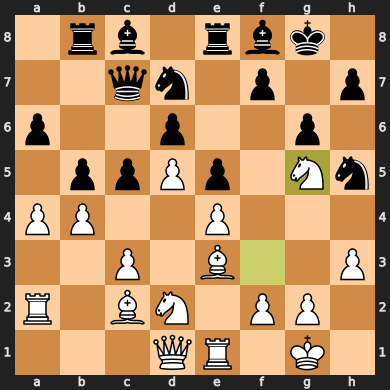

In [12]:
topk_index = 0

demo_board = LczeroBoard(fen="1rb1rbk1/2qn1p1p/p2p2p1/1ppPp2n/PP2P3/2P1BN1P/R1BN1PP1/3QR1K1 w - - 0 22")
move = demo_board.decode_move(legal_indices[topk_indices[topk_index]])
demo_board.push(move)
display(demo_board)

In [13]:
policy_index = legal_indices[topk_indices[topk_index]]


def init_targets(td, _):
    return TensorDict(out=td["policy"][..., policy_index], batch_size=td.batch_size)


td = TensorDict(board=cnn_model.prepare_boards(board), batch_size=1)
modules_to_attribute = {
    ":policy/conv2:": DimsConfig(
        feature_dims=(2, 3),
        pooling_dims=(1,),
    )
}

saliency_context = GradCAM(modules_to_attribute, init_attr_targets=init_targets)
with saliency_context.prepare(cnn_model) as hooked_model:
    output = hooked_model(td)

svg_board, svg_colorbar = board.render_heatmap(
    output.get(("attr", ":policy/conv2:")).view(64).detach(), normalise="abs"
)
display(IPython.display.HTML(f"{svg_board}{svg_colorbar}"))